# *May the best explanation win*: 
# A tutorial on benchmarking and tuning model explanations

Which metrics can we use to benchmark different pixel attribution techniques ?

How can we measure if a model explanation is good or bad?

What kind of problems do metrics for model explanatiosn have that we should be aware of ?

And maybe most importantly - how can we use this in practice to tune our explanation ?

In this tutorial you will:
- Get an overview of different model explanation metrics used (in computer vision) to rank explanation methods.
- Learn how to get the metrics in the pytorch-grad-cam package.
- See examples of how to use these metrics to get better explanations for your images.

## Evaluating the explanations by using them for localization

In 2016 we had the first explainability methods comming out - Class Activation Maps for Networks with Global Averge Pooling (https://arxiv.org/abs/1512.04150v1) and then soon after GradCAM (https://arxiv.org/abs/1610.02391).

The CAM paper suggested evaluating the explanations by extracting bounding boxes out of them, and comparing to the bounding boxes in the ILSVRC dataset (a subset of Imagenet that has bounding box annotations).
The reasoning here is that if the explanation is good, and correct, it will probably overlap with the actual object.

The bounding box itself is created by just keeping the top 20% highest pixels in the CAM and taking the largest connected compnent.

![image.png](bbox.png)
*Image from https://arxiv.org/abs/1512.04150v1*


That's useful in itself, but it's just a proxy to what we really want - an explanation that reflects the model decision process. 
Imagine that our model is able to identify a cat only by its ears, but didn't learn anything else. It's body and fur - irrelevant, our model doesn't use them.

A good explanation here would highlight what the model is using - the ears.
The overlap between the bounding box of our ideal explanation (around the cat ears) and the cat bounding box would be low.
And we want it to be low, since it's not using the cat's body.

Similarly, the Grad-CAM suggested using something called "the pointing game".
You get the point with the highest value in the CAM, and check if it falls inside a bounding box.
That's actually a bit better, but still is a limitted metric.

The Score-CAM paper (https://arxiv.org/abs/1910.01279) suggested evaluating with localization by measuring the total sum of CAM pixels inside the bounding box.

## Evaluating the explanations by using them to pertubate the image and predicting again
Then came the GradCAM++ paper and offered some metrics that are still widely used.

You multiply the image (before image-net normalization) by the explanation. Only regions that score high will still be visible. 
![image-2.png](multimage.png)
*Image from the GradCAM++ paper (https://arxiv.org/abs/1710.11063)*


Then you run the new modified "dark" image through the model, and check the new category scores.

The metrics are:
- (Smaller value is better) Drop in Confidence: What's the percentage drop of the condience ? (or 0 if the confidence increased).
The confidence is assumed to drop a bit since we're removing details.

- (Larger value is better) Increase in confidence: In how many of the cases did the confidence increase.

You might ask: why do we need two complementory metrics, why not just measure the average change in confidence.
I'm not sure, I suspect that would be better.

This is a way of measuring the "fidelity" or "faithfulness" of the explanation. We want a good explanation to reflect the actual regions that the model is using.


### Side comment: Metric reproducability and small implementation details

In the GradCAM++ paper image above the masked images are black, so it looks like they are multiplying the original image,
before the image-net normalization.

I'm pretty sure that most of the methods that came after that, multiplied the tensor in the input to the model, after image-net normalization.

Both should be similar, but with difference that maybe black pixels (multiplying pre normalization) make the images look more different than the distribution of natural images, and maybe that has some effect.

No one is sharing the CAM evaluation code, and no one is commenting about that implementation detail in the papers, so I'm pretty sure the different papers are using differnt metrics ;-) 


Before moving on to other metrics, lets take a first look at how to use these metrics in the pytorch-grad-cam package.


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"  # 将 "0" 替换为你想指定的 GPU ID


In [2]:
import sys

sys.path.append('/home/caihuaiguang/DSG/pytorch-shapley-cam')

# 验证路径是否已添加
print(sys.path)


['/media/caihuaiguang/miniconda3/envs/cords/lib/python38.zip', '/media/caihuaiguang/miniconda3/envs/cords/lib/python3.8', '/media/caihuaiguang/miniconda3/envs/cords/lib/python3.8/lib-dynload', '', '/media/caihuaiguang/miniconda3/envs/cords/lib/python3.8/site-packages', '/home/caihuaiguang/DSG/InfoBatch', '/home/caihuaiguang/DSG/pytorch-shapley-cam']


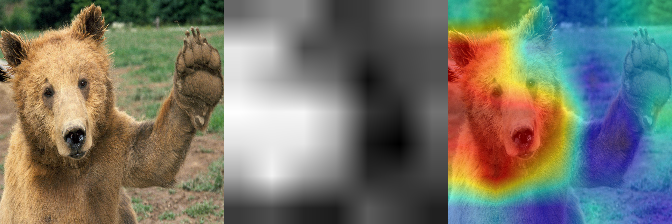

In [3]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import cv2
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image

model = models.resnet50(pretrained=True)
model.eval()
image_url = "https://th.bing.com/th/id/R.94b33a074b9ceeb27b1c7fba0f66db74?rik=wN27mvigyFlXGg&riu=http%3a%2f%2fimages5.fanpop.com%2fimage%2fphotos%2f31400000%2fBear-Wallpaper-bears-31446777-1600-1200.jpg&ehk=oD0JPpRVTZZ6yizZtGQtnsBGK2pAap2xv3sU3A4bIMc%3d&risl=&pid=ImgRaw&r=0"
img = np.array(Image.open(requests.get(image_url, stream=True).raw))
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# The target for the CAM is the Bear category.
# As usual for classication, the target is the logit output
# before softmax, for that category.
targets = [ClassifierOutputTarget(295)]
target_layers = [model.layer4]
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)

The confidence increase percent: 0.005073810461908579
The visualization of the pertubated image for the metric:


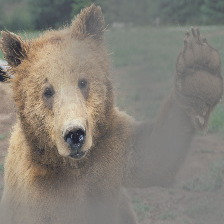

In [4]:
# Now lets see how to evaluate this explanation:
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget

# For the metrics we want to measure the change in the confidence, after softmax, that's why
# we use ClassifierOutputSoftmaxTarget.
targets = [ClassifierOutputSoftmaxTarget(295)]
cam_metric = CamMultImageConfidenceChange()
scores, visualizations = cam_metric(input_tensor, grayscale_cams, targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase percent: {100*score}")
print("The visualization of the pertubated image for the metric:")
Image.fromarray(visualization)

The confidence increase here is positive.

That's a good sign - the CAM reduced noise from other parts of the image and retains the information that triggers the category output.

- The "drop in confidence" metric here from the gradcam++ paper would be 0 (since it's negative).
- The "increase in confidence" metric would be 1 (since there is an increase in confidence).
For completeness, lets see how we can use those metrics directly:

In [5]:
from pytorch_grad_cam.metrics.cam_mult_image import DropInConfidence, IncreaseInConfidence
print("Drop in confidence", DropInConfidence()(input_tensor, grayscale_cams, targets, model))
print("Increase in confidence", IncreaseInConfidence()(input_tensor, grayscale_cams, targets, model))

Drop in confidence [0.]
Increase in confidence [1.]


In [6]:
from pytorch_grad_cam.metrics.ADCC import ADCC
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams_2 = cam(input_tensor=input_tensor*grayscale_cams, targets=targets)
print("ADCC", ADCC()(input_tensor,grayscale_cams,targets,model,GradCAM(model=model, target_layers=target_layers)))

tensor([[[[-0.3588, -0.3727, -0.4074,  ..., -0.8329, -0.8561, -0.8174],
          [-0.3727, -0.3657, -0.4005,  ..., -0.7478, -0.7865, -0.8252],
          [-0.4213, -0.4005, -0.4282,  ..., -0.6627, -0.6705, -0.7091],
          ...,
          [ 0.3414,  0.3855,  0.3855,  ...,  0.0819,  0.0929,  0.0731],
          [ 0.3454,  0.4255,  0.3534,  ...,  0.0665,  0.1082,  0.1082],
          [ 0.3574,  0.3654,  0.3534,  ...,  0.0643,  0.0995,  0.0951]],

         [[-0.1156, -0.1653, -0.1936,  ..., -0.6111, -0.6744, -0.6270],
          [-0.1582, -0.1865, -0.2007,  ..., -0.4451, -0.4846, -0.5241],
          [-0.2149, -0.2291, -0.2575,  ..., -0.3818, -0.3739, -0.4134],
          ...,
          [ 0.2484,  0.2852,  0.2566,  ...,  0.0846,  0.1003,  0.0644],
          [ 0.2648,  0.3302,  0.2198,  ...,  0.0846,  0.1340,  0.1295],
          [ 0.2975,  0.2852,  0.2198,  ...,  0.0622,  0.1115,  0.1115]],

         [[-0.2158, -0.2582, -0.2864,  ..., -0.6025, -0.6812, -0.6340],
          [-0.2511, -0.2723, -

Similarly, we could pertubate the image by deleting pixels with high values in the CAM.
In this case, we would WANT a larger drop in the confidence.

The confidence increase percent: -0.00022310041822493076
The visualization of the pertubated image for the metric:


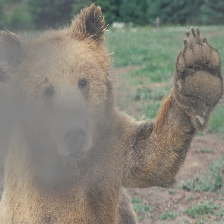

In [7]:
inverse_cams = 1 - grayscale_cams
scores, visualizations = CamMultImageConfidenceChange()(input_tensor, inverse_cams, targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase percent: {score}")
print("The visualization of the pertubated image for the metric:")
Image.fromarray(visualization)

# We deleted important parts, how come it became more confident ?
When we pertubate the supposedly impotant parts, the model actually becomes more confident than before.
Maybe the CAM explanation wasn't telling us the whole story in the first place, and there are other parts that were important as well that is was missing.
This shows us the importance of using complementory metrics, and how these metrics can contradict each other.

Another problem here however is that the CAM itself has values that are medium range all over it:
after the pertubation, we can still see the bear in the image.
Getting the Image*CAM to work requires the CAM to have a distribution that's more stretched.

This is the motivation for other methods that threshold the CAM and create binary masks.
Lets completely remove the highest scoring 25%, and see that the model confidence drops now.

In [8]:
thresholded_cam = grayscale_cams < np.percentile(grayscale_cams, 75)
scores, visualizations = CamMultImageConfidenceChange()(input_tensor, thresholded_cam, targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase: {score}")
print("The visualization of the pertubated image for the metric:")
Image.fromarray(visualization)

But the image above doesn't look quite natural, does it ?

## Remove and Retrain (ROAR)
https://arxiv.org/abs/1806.10758

When you pertubate the image by modifying the highest scoring regions, and the confidence decreases:
- Is it because the explanation is good and all of cues the model was using were now removed ?
- Or is it because of the pertubation method itself that's causing a distribution shift in the data: maybe the new image is so different than what the model expects, so un-natural, that the confidence drops. 

*Maybe it thinks that all that gray above is a road, or an airplane.*

The claim in this paper is that the high confidence drops the different methods show, is actually because of the latter.
When they pertubate the images by removing highest scoring pixels and then retrain, they the model is still actually much more accurate than expected.
Because of this, they argue that we should retrain on the pertubated images to be able to adapt to the pertubations. If the explanation method still scores high - we know we can trust it much more.

They also show that common methods (altough they focused more on gradient based method and not on CAM methods) are worse on this benchmark then classical computer vision edge detector (Sobel) that doesn't depend on the model parameters at all.
So basically some methods that claim they are better than others, aren't really.

Benchmarking against random explanations, or explanations that don't depend on the model (like edge detection), is a very interesting idea in itself, so lets take a look at that.

The confidence increase: -0.000837908883113414
The visualization of the pertubated image for the metric:


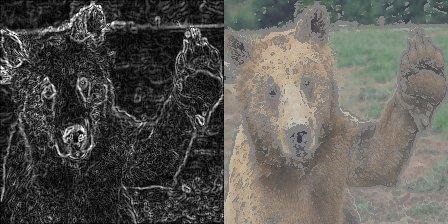

In [ ]:
from pytorch_grad_cam.sobel_cam import sobel_cam

sobel_cam_grayscale = sobel_cam(np.uint8(img * 255))
thresholded_cam = sobel_cam_grayscale < np.percentile(sobel_cam_grayscale, 75)

cam_metric = CamMultImageConfidenceChange()
scores, visualizations = cam_metric(input_tensor, [thresholded_cam], targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase: {score}")
print("The visualization of the pertubated image for the metric:")
sobel_cam_rgb = cv2.merge([sobel_cam_grayscale, sobel_cam_grayscale, sobel_cam_grayscale])
Image.fromarray(np.hstack((sobel_cam_rgb, visualization)))


Ok, good. So our CAM scores higher than a classic edge detector on this benchmark.
That's good news !

Back to the ROAR method - 
Re-training a model on the pertubated images is very expensive.
We don't even always know in advance what explanation method we want to chose.
For many users this won't be a practical approach. Altough if the stakes are high and you want to be 100% sure about the explanation, this is something to consider.

So what can we do?

# Sanity Checks for Saliency Metrics
https://arxiv.org/abs/1912.01451

This paper introduces a metric called "Area Over the Perturbation Curve" - AOPC, which is the average confidence drop over different removal percentiles.
(We will later call that MostRelevantFirstAverage or LeastRelevantFirstAverage since I think it's a bit more explicit and clear, but it's the same).

They check different imputation strategies:
- Replacing pixels that need to be deleted, by random values.
- Replacing pixels that need to be deleted, by the mean (for R,G,B separately) in the image.
- Removing the highest attention pixels first: Most Relevant First (MORF).
- Removing the least attention pixels first: Least Relevant First (LERF).

And then check how different algorithms differ on average acrross a dataset, but also for different individual images.
Ultimately we care about an individual image - we want to make sure the explanation we use for it is reliable.

The conclusion (in my own words) is that it's a wild west.
Different imputation strategies give different results. MORF and LERF give different results for different algorithms, and basically measure different properties.
For the same image, it's difficult to know in advance what explanation strategy will work best.

This means that going forward, we will need a combination of metrics, will need take in mind the imputation strategy, and will definately need to look at every image individually. 


# ROAD: Remove and Debias
https://arxiv.org/abs/2202.00449

The claim in this paper is that the perbutbated image (they use the term "imputed image") itself is leaking data. 
Even the previous ROAR method can suffer from that.
They use a beutiful example so I'm going to just paste that here:

*Imagine a two-class problem that consists of detecting whether an object is located on the
left or the right side of an image. A reasonable attribution
method masks out pixels on the left or the right depending
on the location of the object. In this case, the retraining
step can lead to a classifier that infers the class just from the
location of the masked out pixels and obtain high accuracy.*

They further show that it's easy to train models that predict what pixels are a result of the pertubation,
and that it's possible to train models with surprising accuracy using just the binary masks.
So it's possible to detect the mask, and then infer things from it.

To solve this they propose a pertubation method that's more difficult to detect. And since it's good and there is less of a distribution shift, training with ROAR doesn't have an advantage any more: different metrics are more consistent with each other.

What they do is replace every pixel that needs to be removed with a weighted average of it's neighbours. Since some of it's neighbours might also need to be removed, we get system of linear equations that we have to solve, to find the new values of the pixels we want to replace.

The confidence increase when removing 25% of the image: -0.0015240011271089315
The confidence increase when removing 10% of the image: -0.001467545866034925
The visualizations:


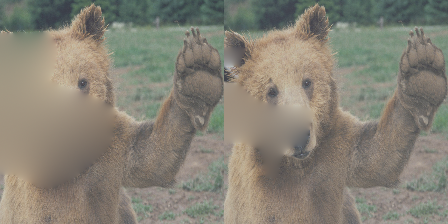

In [ ]:
from pytorch_grad_cam.metrics.road import ROADMostRelevantFirst
cam_metric = ROADMostRelevantFirst(percentile=75)
scores, visualizations = cam_metric(input_tensor, grayscale_cams, targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase when removing 25% of the image: {score}")

cam_metric = ROADMostRelevantFirst(percentile=90)
scores, visualizations = cam_metric(input_tensor, grayscale_cams, targets, model, return_visualization=True)
score = scores[0]
visualization_10 = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization_10 = deprocess_image(visualization_10)
print(f"The confidence increase when removing 10% of the image: {score}")
print("The visualizations:")
Image.fromarray(np.hstack((visualization, visualization_10)))

This is much better than replacing with the gray.
But to be honest it's still quite distinguishable from the rest of the image since it's so blurry.
So more work is needed to make this a convincing pertubation.
GANs can be useful here (and were used in the literature for this), but are computationally expensive.


How much from the image should we remove ?

That depends on the object size and varies, so it makes sense to try different percentiles and then take the average, if we want a more robust metric.

In [ ]:
from pytorch_grad_cam.metrics.road import ROADMostRelevantFirstAverage
cam_metric = ROADMostRelevantFirstAverage(percentiles=[20, 40, 60, 80])
scores = cam_metric(input_tensor, grayscale_cams, targets, model)
print(f"The average confidence increase with ROAD accross 4 thresholds: {scores[0]}")
scores = cam_metric(input_tensor, [sobel_cam_grayscale], targets, model)
print(f"The average confidence increase for Sobel edge detection with ROAD accross 4 thresholds: {scores[0]}")

The average confidence increase with ROAD accross 4 thresholds: -0.0013974786270409822
The average confidence increase for Sobel edge detection with ROAD accross 4 thresholds: -1.8954509869217873e-05


How would this metric look if we just zerod out the cam completely ?

In [ ]:
cam_metric = ROADMostRelevantFirstAverage(percentiles=[20, 40, 60, 80])
scores = cam_metric(input_tensor, grayscale_cams * 0, targets, model)
print(f"Empty CAM, Most relevant first avg confidence increase with ROAD accross 4 thresholds: {scores[0]}")

Empty CAM, Most relevant first avg confidence increase with ROAD accross 4 thresholds: -0.0014888105215504766


Uh oh.
Of course the drop in confidence will be huge if we corrupt the CAM completely.
To balance that we can see what happens when we delete the least relevant first, we would want the confidence increase to be larger.
And for an empty CAM as baseline - the confidence increase should be very negative (bad) for LeastRelevantFirst.

In [ ]:
from pytorch_grad_cam.metrics.road import ROADLeastRelevantFirstAverage, ROADMostRelevantFirstAverage
cam_metric = ROADLeastRelevantFirstAverage(percentiles=[20, 40, 60, 80])
scores = cam_metric(input_tensor, grayscale_cams * 0, targets, model)
print(f"Empty CAM, Least relevant first avg confidence increase with ROAD accross 4 thresholds: {scores[0]}")

Empty CAM, Least relevant first avg confidence increase with ROAD accross 4 thresholds: -0.0014887924771755934


Good.
To finalize this, lets use a custom single metric that is a combination of Least Relevant First and Most Relevant First:

(Least Relevant First - Most Relevant First) / 2, accross different thresholds.

This way we get a single metric and don't have to inspect both.

In [ ]:
from pytorch_grad_cam.metrics.road import ROADCombined
cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
scores = cam_metric(input_tensor, grayscale_cams * 0, targets, model)
print(f"Empty CAM, Combined metric avg confidence increase with ROAD accross 4 thresholds (positive is better): {scores[0]}")

Empty CAM, Combined metric avg confidence increase with ROAD accross 4 thresholds (positive is better): 5.494803190231323e-08


So we have ethods that can rank our model explanations.
We saw we can compare that against a sobel edge detector as a sanity check to see we're better.

Lets see how to use this to get better explanations.

We will also use a toy RandomCAM that generates CAMs with random uniform values in the range [-1, 1] for the spatial activations.
If our CAM methods are that smart, they should be much better than it, on average.

In [ ]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenGradCAM,  XGradCAM, LayerCAM, AblationCAM, RandomCAM, ShapleyCAM, HiResCAM, ScoreCAM

# Showing the metrics on top of the CAM : 
def visualize_score(visualization, score, name, percentiles):
    visualization = cv2.putText(visualization, name, (10, 20), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, "(Least first - Most first)/2", (10, 40), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"Percentiles: {percentiles}", (10, 55), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)    
    visualization = cv2.putText(visualization, "Remove and Debias", (10, 70), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA) 
    visualization = cv2.putText(visualization, f"{score:.5f}", (10, 85), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)    
    return visualization
    
def benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category=281):
    methods = [("GradCAM", GradCAM(model=model, target_layers=target_layers)),
               ("HiResCAM", HiResCAM(model=model, target_layers=target_layers)),
               ("LayerCAM", LayerCAM(model=model, target_layers=target_layers)),
               ("GradCAM++", GradCAMPlusPlus(model=model, target_layers=target_layers)),
               ("XGradCAM", XGradCAM(model=model, target_layers=target_layers)),
               ("ShapleyCAM", ShapleyCAM(model=model, target_layers=target_layers)),
               ("ScoreCAM", ScoreCAM(model=model, target_layers=target_layers)),
               ("EigenGradCAM", EigenGradCAM(model=model, target_layers=target_layers)),
               ("AblationCAM", AblationCAM(model=model, target_layers=target_layers)),
               ("RandomCAM", RandomCAM(model=model, target_layers=target_layers))]

    cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
    targets = [ClassifierOutputTarget(category)]
    # targets = [ClassifierOutputSoftmaxTarget(category)]
    metric_targets = [ClassifierOutputSoftmaxTarget(category)]
    
    visualizations = []
    percentiles = [10, 50, 90]
    for name, cam_method in methods:
        with cam_method:
            attributions = cam_method(input_tensor=input_tensor, 
                                      targets=targets, eigen_smooth=eigen_smooth, aug_smooth=aug_smooth)
        attribution = attributions[0, :]    
        scores = cam_metric(input_tensor, attributions, metric_targets, model)
        score = scores[0]
        visualization = show_cam_on_image(cat_and_dog, attribution, use_rgb=True)
        visualization = visualize_score(visualization, score, name, percentiles)
        visualizations.append(visualization)
    return Image.fromarray(np.hstack(visualizations))

cat_and_dog_image_url = "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/both.png"
cat_and_dog = np.array(Image.open(requests.get(cat_and_dog_image_url, stream=True).raw))
cat_and_dog = np.float32(cat_and_dog) / 255
input_tensor = preprocess_image(cat_and_dog, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer4]

model.cuda()
input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False)

RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

So EigenGradCAM is a clear winner, not unsurprisingly since it also looks smoother.

What about if we use an earlier layer with lower level features?

In [ ]:
target_layers = [model.layer4[-1]]
benchmark(input_tensor, target_layers)

RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

In [ ]:
np.random.seed(0)
benchmark(input_tensor, target_layers)

RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

100%|██████████| 64/64 [00:02<00:00, 26.57it/s]


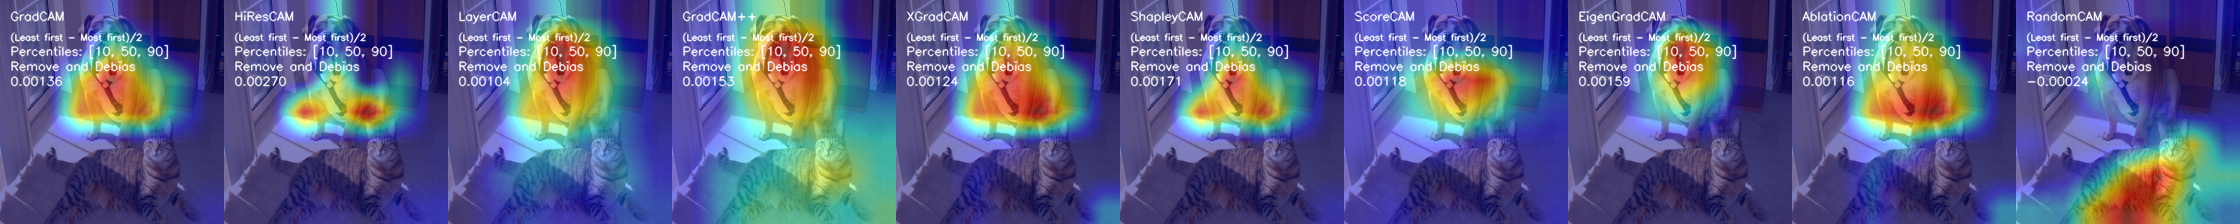

In [ ]:
# Let's look how it looks for one of the dog categories (that the model is much less confident about)
np.random.seed(0)
benchmark(input_tensor, target_layers, category=246)

So using this metric we can see that:
- The different methods perform quite different.
- You can use the metric to tune parameters like which layer or explainability method to use.
- The explanations are quite different between the different methods.
- A Random CAM isn't always that behind some of the methods, but still they are much better than random..
In any case we need to be suspicious about the results and double check them against benchmarks like RandomCAM or Sobel, before extracting too many insights from them.